<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: Predicting West Nile Virus in Mosquitoes

In [221]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, plot_roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import time
import re
import datetime
import random
import pickle
import geopandas as gpd
from shapely.geometry import Point, Polygon
from matplotlib import dates

pd.set_option('display.max_columns', 50)
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
street_map = gpd.read_file('data/geo_export_a6957f22-b168-4cee-b03c-0bcc9815308c.shp')

In [3]:
train = pd.read_csv('data/train.csv/train.csv')
train['Date'] = pd.to_datetime(train['Date'])

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
 12  geometry                10506 non-null  geomet

In [4]:
geometry = [Point(xy) for xy in zip(train['Longitude'], train['Latitude'])]

In [5]:
geo_train = gpd.GeoDataFrame(train,
                            crs={'init': 'epsg:4326'},
                             geometry=geometry)
geo_train.head()

C:\HA\Python\Anaconda\envs\geoenv\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,geometry
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,POINT (-87.80099 41.95469)
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,POINT (-87.80099 41.95469)
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,POINT (-87.76928 41.99499)
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,POINT (-87.82481 41.97409)
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,POINT (-87.82481 41.97409)


In [6]:
geo_train_groupby = geo_train.dissolve(by='Address', aggfunc='sum')
geo_train_groupby.head(3)

,geometry,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
Address,,,,,,,
"1000 East 67th Street, Chicago, IL 60637, USA",POINT (-87.60088 41.77322),1280,5346.971520,-11212.912640,1024,852,4
"1000 North Central Park Avenue, Chicago, IL 60651, USA",POINT (-87.71679 41.89923),1260,5279.302980,-11052.315288,1134,1802,8
"1000 South California Avenue, Chicago, IL 60612, USA",POINT (-87.69629 41.86911),280,1172.334996,-2455.496204,252,125,0


# Where are the traps and which traps have returned positive

Text(0.5, 1.0, 'Location of of traps with positive returns - All Years')

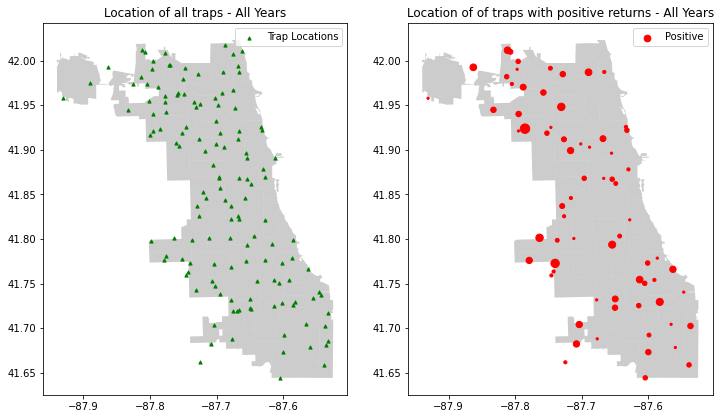

In [7]:
fig,ax = plt.subplots(figsize=(12,12), nrows=1, ncols=2)
street_map.plot(ax=ax[0], alpha=0.4, color='grey')
street_map.plot(ax=ax[1], alpha=0.4, color='grey')
geo_train_groupby[geo_train_groupby['WnvPresent']>0].plot(ax=ax[1], markersize=geo_train_groupby['WnvPresent']*5, color='red', marker='o', label='Positive')
geo_train_groupby.plot(ax=ax[0], markersize=10, color='green', marker='^', label='Trap Locations')
ax[0].legend()
ax[0].set_title('Location of all traps - All Years')
ax[1].legend()
ax[1].set_title('Location of of traps with positive returns - All Years')

No discernible pattern of spread, though some neighborhoods have a higher density of infected mosquitos.
Variable: WNV Density equal to value at that address

# Does higher number of mosquitos affect probability of WNV present?

Text(0.5, 1.0, 'Batch size where WNV is absent')

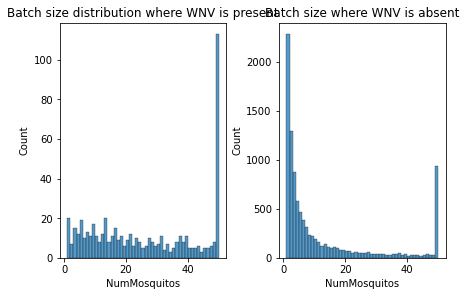

In [17]:
fig,ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
sns.histplot(data=geo_train[geo_train['WnvPresent']==1], binwidth=1, x='NumMosquitos', ax=ax[0])
ax[0].set_title('Batch size distribution where WNV is present')
sns.histplot(data=geo_train[geo_train['WnvPresent']==0], binwidth=1, x='NumMosquitos', ax=ax[1])
ax[1].set_title('Batch size where WNV is absent')

Most of the WNV occurs when batch size is 50. Variable: NumMosquitos

# Which months have higher WNV occurrences?

<AxesSubplot:xlabel='Date', ylabel='WnvPresent'>

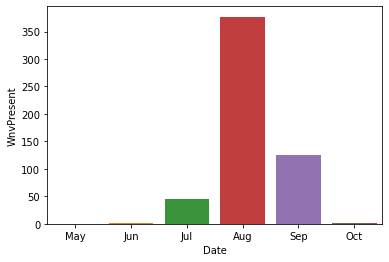

In [24]:
date_groupby = geo_train.groupby(geo_train['Date'].dt.month)['WnvPresent'].sum().reset_index()
date_groupby['Date'] = date_groupby['Date'].map({5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct'})
sns.barplot(data=date_groupby, x='Date', y='WnvPresent')

Variable: Month

# Which species of mosquitos carry WNV?

<AxesSubplot:xlabel='WnvPresent', ylabel='Species'>

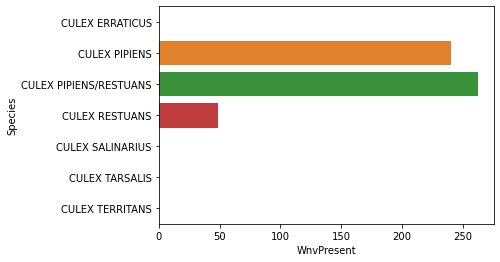

In [30]:
species_groupby = geo_train.groupby('Species')['WnvPresent'].sum().reset_index()
sns.barplot(data=species_groupby, y='Species', x='WnvPresent', orient='h')

Variable: Species of mosquito

# Sprays

In [60]:
spray = pd.read_csv('data/spray.csv/spray.csv')
spray['Date'] = pd.to_datetime(spray['Date'])
spray = spray[spray['Latitude'] < 42.3] # remove outliers outside of Chicago
spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14740 entries, 95 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       14740 non-null  datetime64[ns]
 1   Time       14156 non-null  object        
 2   Latitude   14740 non-null  float64       
 3   Longitude  14740 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 575.8+ KB


In [61]:
geometry_spray = [Point(xy) for xy in zip(spray['Longitude'], spray['Latitude'])]

In [62]:
geo_spray = gpd.GeoDataFrame(spray,
                            crs={'init': 'epsg:4326'},
                             geometry=geometry_spray)
geo_spray.head()

C:\HA\Python\Anaconda\envs\geoenv\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,Date,Time,Latitude,Longitude,geometry
95,2011-09-07,7:52:52 PM,41.981433,-87.787777,POINT (-87.78778 41.98143)
96,2011-09-07,7:53:02 PM,41.980998,-87.787778,POINT (-87.78778 41.98100)
97,2011-09-07,7:53:12 PM,41.980560,-87.787762,POINT (-87.78776 41.98056)
98,2011-09-07,7:53:22 PM,41.980198,-87.787758,POINT (-87.78776 41.98020)
99,2011-09-07,7:53:32 PM,41.979752,-87.787765,POINT (-87.78776 41.97975)


# Spray juxtaposed Positive Traps

In [69]:
geo_train_groupby_2011_2013 = geo_train[geo_train['Date'].dt.year.isin([2011,2013])].dissolve(by='Address', aggfunc='sum')

Text(0.5, 1.0, 'Locations of sprays juxtaposed against Positive Traps, 2011 & 2013')

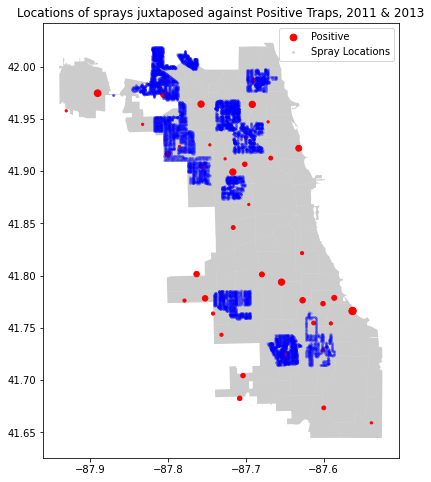

In [71]:
fig,ax = plt.subplots(figsize=(8,8))
street_map.plot(ax=ax, alpha=0.4, color='grey')

geo_train_groupby_2011_2013[geo_train_groupby_2011_2013['WnvPresent']>0].plot(ax=ax, markersize=geo_train_groupby['WnvPresent']*5, color='red', marker='o', label='Positive')

geo_spray.plot(ax=ax, markersize=3, color='blue', marker='x', label='Spray Locations', alpha=0.2)

ax.legend()
ax.set_title('Locations of sprays juxtaposed against Positive Traps, 2011 & 2013')

We see that certain neighborhoods are sprayed frequently (why? how frequent?) while others were never sprayed at all. It also seems that those areas with alot of sprays have either no or low concentrations of WNV. Variable: whether location is earmarked for spray

# Weather

From Wikipedia, we know that the epidemiology of WNV is dependent on:
- Humidity (higher favors WNV)
- Temperature (higher favors mosquito replication, WNV replication and efficiency)
- Precipitation (higher favors WNV)
- Wind Speed (higher favors dispersal of mosquitos)

In [205]:
def find_average_value(main_df, index, column):
    
    station_missing = index['Station']
    
    i = -1
    date_missing_prev = index['Date'] + pd.Timedelta(days=-1)
    while main_df[(main_df['Station']==station_missing) & (main_df['Date']==date_missing_prev)][column].values[0] == 'M':
        i -= 1
        date_missing_prev = index['Date'] + pd.Timedelta(days=i)
    
    j = 1
    date_missing_next = index['Date'] + pd.Timedelta(days=1)
    while main_df[(main_df['Station']==station_missing) & (main_df['Date']==date_missing_next)][column].values[0] == 'M':
        j += 1
        date_missing_next = index['Date'] + pd.Timedelta(days=j)
        
        
    prev_row_value = main_df[(main_df['Station']==station_missing) & (main_df['Date']==date_missing_prev)][column].values[0]
    next_row_value = main_df[(main_df['Station']==station_missing) & (main_df['Date']==date_missing_next)][column].values[0]

    return (float(prev_row_value) + float(next_row_value))/2

In [206]:
weather = pd.read_csv('data/weather.csv/weather.csv')
weather['Date'] = pd.to_datetime(weather['Date'])

# Fill non-numeric values
weather['PrecipTotal'] = weather['PrecipTotal'].apply(lambda x: 0 if x == '  T' else x)
weather['Tavg'] = weather.apply(lambda x: (float(x['Tmax']) + float(x['Tmin']))/2 if x['Tavg'] == 'M' else x['Tavg'], axis=1)
weather['WetBulb'] = weather.apply(lambda x: find_average_value(weather, x, 'WetBulb') if x['WetBulb'] == 'M' else x['WetBulb'], axis=1)
weather['PrecipTotal'] = weather.apply(lambda x: find_average_value(weather, x, 'PrecipTotal') if x['PrecipTotal'] == 'M' else x['PrecipTotal'], axis=1)
weather['AvgSpeed'] = weather.apply(lambda x: find_average_value(weather, x, 'AvgSpeed') if x['AvgSpeed'] == 'M' else x['AvgSpeed'], axis=1)

weather['DewPoint'] = weather['DewPoint'].astype(float)
weather['WetBulb'] = weather['WetBulb'].astype(float)
weather['Tavg'] = weather['Tavg'].astype(float)
weather['PrecipTotal'] = weather['PrecipTotal'].astype(float)
weather['AvgSpeed'] = weather['AvgSpeed'].astype(float)

weather1 = weather[weather['Station']==1]
weather1['yearmonth'] = weather1['Date'].values.astype('datetime64[M]')
weather1['Latitude'] = 41.995
weather1['Longitude'] = -87.933

weather2 = weather[weather['Station']==2]
weather2['yearmonth'] = weather2['Date'].values.astype('datetime64[M]')
weather2['Latitude'] = 41.786
weather2['Longitude'] = -87.752

In [207]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   float64       
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   float64       
 7   WetBulb      2944 non-null   float64       
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

In [109]:
weather1.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,yearmonth,Latitude,Longitude
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2,2007-05-01,41.995,-87.933
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4,2007-05-01,41.995,-87.933
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9,2007-05-01,41.995,-87.933
6,1,2007-05-04,66,49,58,4,41,50,7,0,0444,1852,RA,0,M,0.0,T,29.31,30.05,10.4,8,10.8,2007-05-01,41.995,-87.933
8,1,2007-05-05,66,53,60,5,38,49,5,0,0443,1853,,0,M,0.0,T,29.40,30.10,11.7,7,12.0,2007-05-01,41.995,-87.933


In [209]:
weather1_groupby = weather1.groupby('yearmonth').agg({
                                                        'DewPoint': 'mean',
                                                        'WetBulb': 'mean',
                                                        'Tavg': 'mean',
                                                        'PrecipTotal': 'sum',
                                                        'AvgSpeed': 'mean'
                                                    })
weather1_groupby.head()

,DewPoint,WetBulb,Tavg,PrecipTotal,AvgSpeed
yearmonth,,,,,
2007-05-01,45.774194,54.387097,64.000000,1.80,10.348387
2007-06-01,56.566667,62.766667,71.566667,2.29,8.860000
2007-07-01,58.967742,64.645161,74.000000,3.86,7.867742
2007-08-01,64.032258,68.032258,75.064516,9.70,6.880645
2007-09-01,53.100000,59.600000,68.266667,1.23,8.866667


In [269]:
weather2_groupby = weather2.groupby('yearmonth').agg({
                                                        'DewPoint': 'mean',
                                                        'WetBulb': 'mean',
                                                        'Tavg': 'mean',
                                                        'PrecipTotal': 'sum',
                                                        'AvgSpeed': 'mean'
                                                    })
weather2_groupby.head()

,DewPoint,WetBulb,Tavg,PrecipTotal,AvgSpeed
yearmonth,,,,,
2007-05-01,45.806452,54.774194,65.241935,1.78,9.967742
2007-06-01,56.633333,63.200000,72.833333,3.26,8.550000
2007-07-01,58.709677,64.870968,74.387097,3.11,8.316129
2007-08-01,64.161290,68.290323,75.709677,8.69,6.919355
2007-09-01,53.000000,60.200000,69.566667,1.29,8.853333


Text(0.5, 1.0, 'Monthly Average WindSpeed')

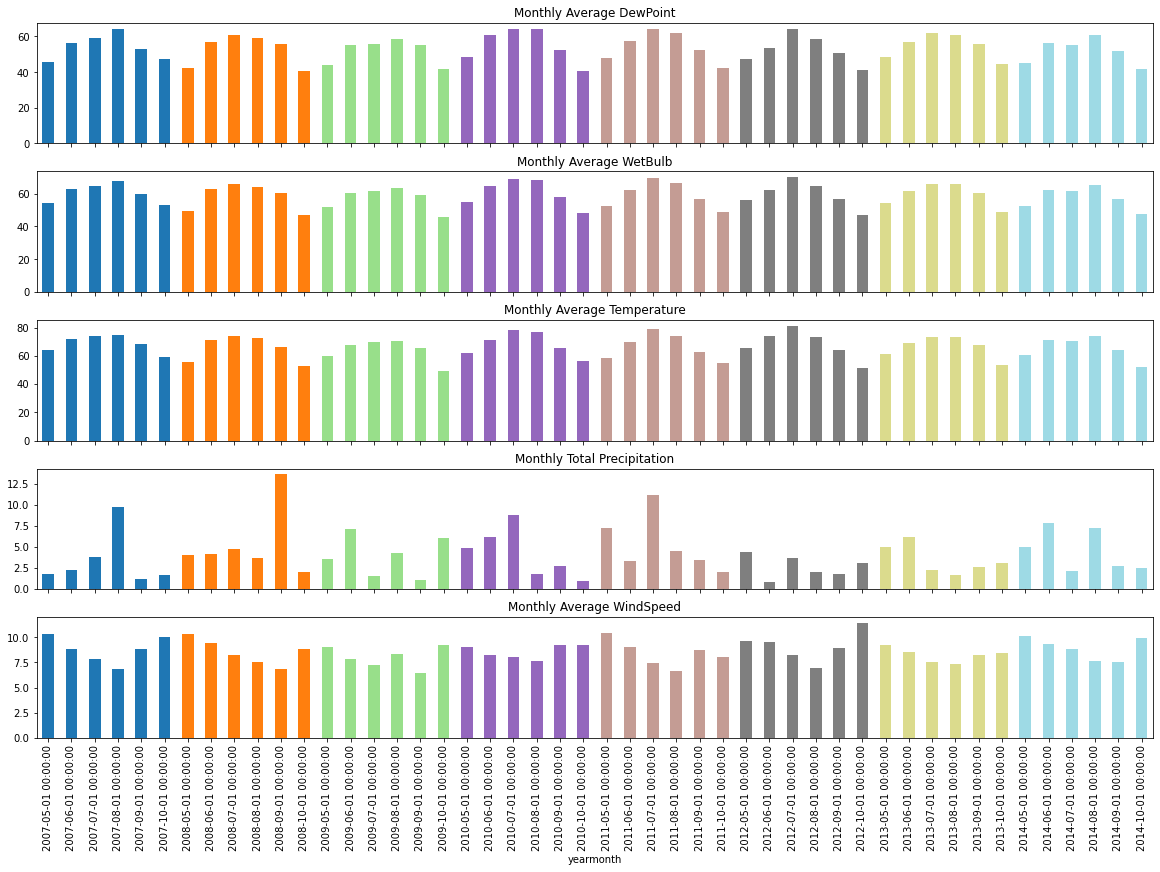

In [244]:
plt.figure(figsize=(16,4))
weather1_groupby['DewPoint'].plot(kind='bar')

Text(0.5, 1.0, 'Monthly Average WindSpeed')

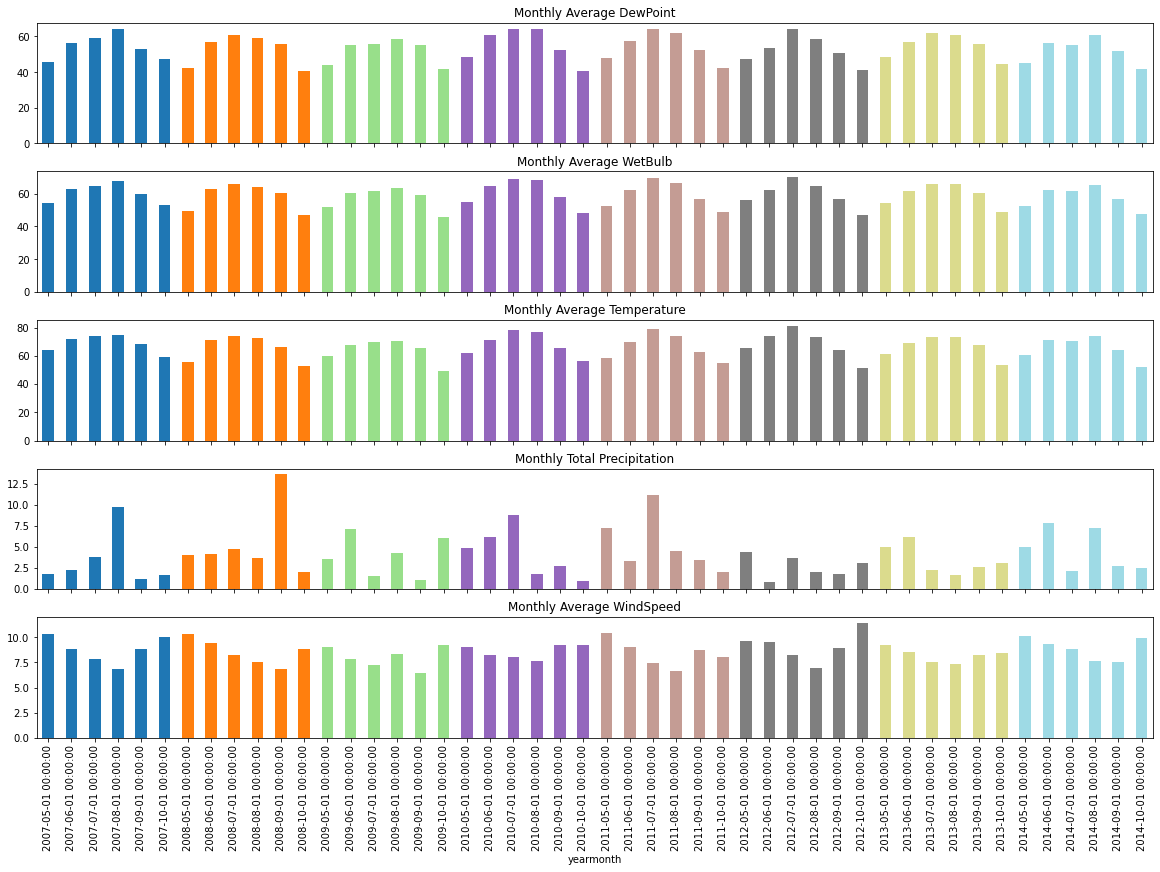

In [267]:
fig,ax = plt.subplots(figsize=(16,12), nrows=5, sharex=True, constrained_layout=True)

yrs = np.unique(weather1_groupby.index.year)
c = cm.get_cmap('tab20', len(yrs))
yrClr = np.zeros((len(weather1_groupby.index.year),4))
for i, v in enumerate(yrs): 
    yrClr[weather1_groupby.index.year==v,:]=c.colors[i,:]

ax[0] = weather1_groupby['DewPoint'].plot(kind='bar', color=yrClr, ax=ax[0])
ax[0].set_title('Monthly Average DewPoint')

ax[1] = weather1_groupby['WetBulb'].plot(kind='bar', color=yrClr, ax=ax[1])
ax[1].set_title('Monthly Average WetBulb')

ax[2] = weather1_groupby['Tavg'].plot(kind='bar', color=yrClr, ax=ax[2])
ax[2].set_title('Monthly Average Temperature')

ax[3] = weather1_groupby['PrecipTotal'].plot(kind='bar', color=yrClr, ax=ax[3])
ax[3].set_title('Monthly Total Precipitation')

ax[4] = weather1_groupby['AvgSpeed'].plot(kind='bar', color=yrClr, ax=ax[4])
ax[4].set_title('Monthly Average WindSpeed')

Dewpoint, Wetbulb and Temperature show a very cyclical monthly pattern, peaking around Jul-Aug. This corroborates with the earlier hypothesis that higher humidity and temperature favors WNV transmission, which is also what we observe earlier, where the most WNV found was in Aug.

Precipitation is a little more volatile and unpredictable, with no clear pattern. This could be due to climate change as well.

Windspeed follows a U shape pattern, where winds are weakest around August. Wind only serves as a dispersal mechanism, and perhaps the earlier months of windy conditions helped to disperse the mosquitos, and when the atmosphere is less windy, mosquitos are able to set up breeding grounds.

Dewpoint, Wetbulb and Temperature are likely to be good predictors of WNV.

Variable: Check average (weather indicator) of the preceding 30 days. Since there is no substantial difference between the readings of the 2 weather stations (expected, given its close proximity), we will take the average readings for any given day.

Text(0.5, 1.0, 'Monthly Average WindSpeed')

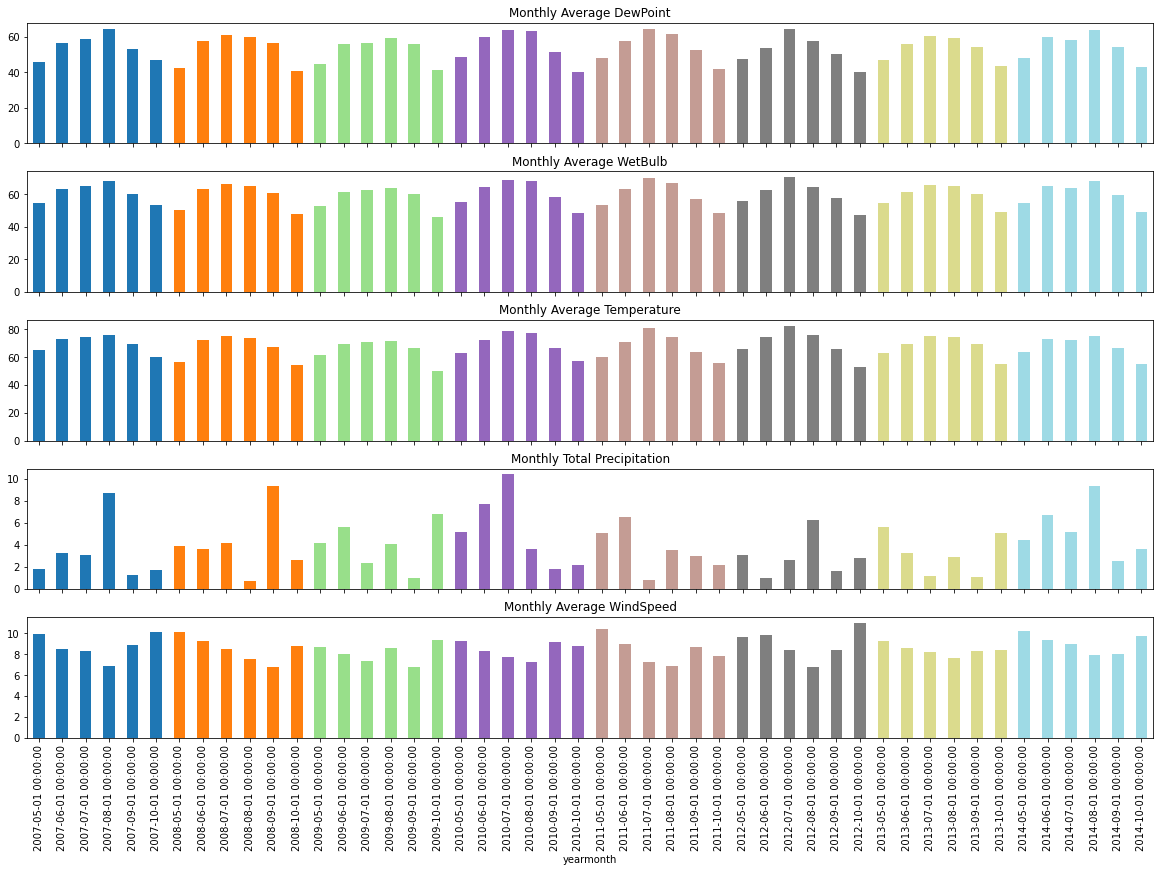

In [270]:
fig,ax = plt.subplots(figsize=(16,12), nrows=5, sharex=True, constrained_layout=True)

yrs = np.unique(weather2_groupby.index.year)
c = cm.get_cmap('tab20', len(yrs))
yrClr = np.zeros((len(weather2_groupby.index.year),4))
for i, v in enumerate(yrs): 
    yrClr[weather2_groupby.index.year==v,:]=c.colors[i,:]

ax[0] = weather2_groupby['DewPoint'].plot(kind='bar', color=yrClr, ax=ax[0])
ax[0].set_title('Monthly Average DewPoint')

ax[1] = weather2_groupby['WetBulb'].plot(kind='bar', color=yrClr, ax=ax[1])
ax[1].set_title('Monthly Average WetBulb')

ax[2] = weather2_groupby['Tavg'].plot(kind='bar', color=yrClr, ax=ax[2])
ax[2].set_title('Monthly Average Temperature')

ax[3] = weather2_groupby['PrecipTotal'].plot(kind='bar', color=yrClr, ax=ax[3])
ax[3].set_title('Monthly Total Precipitation')

ax[4] = weather2_groupby['AvgSpeed'].plot(kind='bar', color=yrClr, ax=ax[4])
ax[4].set_title('Monthly Average WindSpeed')

In [273]:
weather_combined = weather.groupby('Date')[['Tavg', 'DewPoint', 'WetBulb', 'PrecipTotal', 'AvgSpeed']].mean()
weather_combined

,Tavg,DewPoint,WetBulb,PrecipTotal,AvgSpeed
Date,,,,,
2007-05-01,67.50,51.0,56.5,0.000,9.40
2007-05-02,51.50,42.0,47.0,0.000,13.40
2007-05-03,57.00,40.0,49.0,0.000,12.55
2007-05-04,61.25,41.5,50.0,0.000,10.60
2007-05-05,60.00,38.5,49.5,0.000,11.75
...,...,...,...,...,...
2014-10-27,65.50,51.5,58.5,0.010,13.25
2014-10-28,57.00,39.0,47.5,0.015,15.10
2014-10-29,44.00,33.0,41.0,0.000,9.45


In [ ]:
weather_combined.to_csv('data/weather.csv/weather_combined.csv')

In [268]:
test = pd.read_csv('data/test.csv/test.csv')
test['Date'] = pd.to_datetime(test['Date'])
test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [78]:
test = pd.read_csv('data/test.csv/test.csv')
test['Date'] = pd.to_datetime(test['Date'])
test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [98]:
test['Date'].dt.year.value_counts()

2010    36557
2008    30498
2012    27115
2014    22123
Name: Date, dtype: int64